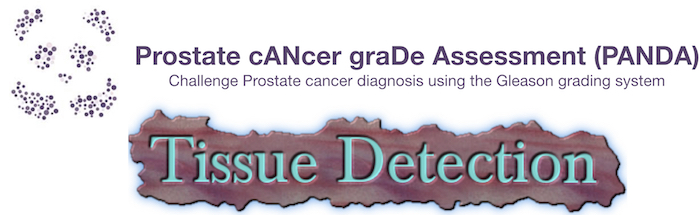

Tissue Detection is a key aspect to research in the domain of computer vision applied to cancer classification. My main focus in this competition so far has been exploring previous work done in this domain and furthering its application towards this dataset. Notebooks in this collection include the following.
* [Base Notebook **(Currently Here)**](https://www.kaggle.com/dannellyz/panda-tissue-detection-size-optimization-70) : Tissue Detection Intro and First Application
* [Base Dataset Generation](https://www.kaggle.com/dannellyz/tissue-detect-td-conv-png-512x512): Notebook to export images to zip file
* [Scaling Bounding Boxes](https://www.kaggle.com/dannellyz/tissue-detect-scaling-bounding-boxes-4xfaster): 4x speed increase to base notebook
* [Tissue Dection Metadata Analysis](https://www.kaggle.com/dannellyz/tissue-detection-bounding-box-metadata-eda-viz/): Exploring features from bounding boxes discovery on the slides

# Tissue Detection and Size Optimization

## Objective:
This notebook leverages academic research and previous repositories in pathology to idnetiify regions of interst (ROIs) in provided slides and optimally crop the full image to contain a the maximum amount of tissue informaiton while minimizing the overall size. This can be used as a preprocessing step in order to remove large swaths of the images that do not conatin meningful data for prediciton. It also greatly improves speed and memory capacity.

## Results:
I have [another notebook](https://www.kaggle.com/dannellyz/tissue-detect-png-512x512-pre-process/) that takes the lessons from this process and directly applies them to the data corpus as pre-processing. Additionally I have made the [pre-processed images](https://www.kaggle.com/dannellyz/panda-preprocessing-tissue-detection/) available as well.

# Getting Strated with the Numpy Images

## Basic Slide Downsample
Downsampling is a process to take the Whole Slide Image (WSI) and get lower lever representations of the slide. The higher the downsampling rate the less resolution the image will have. to start this walk through we use a very high downsampling in order to prove the concept and at the end with a low downsampling to show the effectiveness.
![Downsample Example](http://dicom.nema.org/Dicom/DICOMWSI/sup145_fromword_files/image010.gif)

## As Numpy Array
Once the image has been downsampled there are many ways it could be represented as best described in the Notebook [Getting Started with the PANDA Dataset -> Using Matplotlib](https://www.kaggle.com/wouterbulten/getting-started-with-the-panda-dataset#Visualizing-masks-(using-matplotlib)). For this notebook we will be working with the slides as Numpy Arrays. As the below examples illustrate the choosen downsample has a big imapct on the size of the representation

In [1]:
#All imports
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import numpy
import pandas as pd
import numpy as np
import cv2
from skimage import morphology
import openslide

#Setup code
slide_dir = "../input/prostate-cancer-grade-assessment/train_images/"
annotation_dir = "../input/prostate-cancer-grade-assessment/train_label_masks/"
train_data_df = pd.read_csv("../input/prostate-cancer-grade-assessment/train.csv")
sample_id_list = list(train_data_df["image_id"].sample(5))
sample_slides = [f"{slide_dir}{slide_id}.tiff" for slide_id in sample_id_list]
sample_annotations = [f"{annotation_dir}{slide_id}_mask.tiff" for slide_id in sample_id_list]

def get_disk_size(numpy_image):
    """ Returns size in MB of numpy array on disk."""
    return (numpy_image.size * numpy_image.itemsize) / 1000000

def plot_figures(figures, nrows = 1, ncols=1):
    #https://stackoverflow.com/a/11172032
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title], aspect='auto')
        axeslist.ravel()[ind].set_title(title)
    plt.tight_layout()
    return plt

print("^ All imports and setup code in above hidden code block. ^")

^ All imports and setup code in above hidden code block. ^


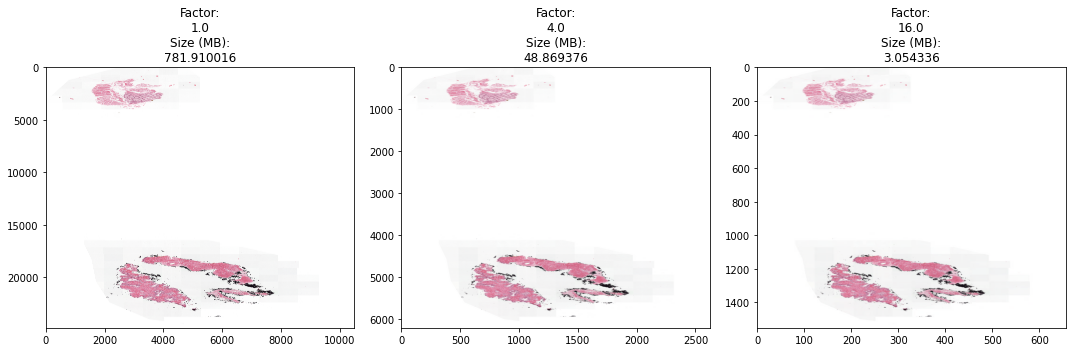

In [2]:
def downsample(wsi, downsampling_factor=16):
    #Select the min downsampling factor 
    #Between the input value and the available values from the slide
    downsampling_factor = min(wsi.level_downsamples, 
                              key=lambda x: abs(x - downsampling_factor))
    
    #Set the level of the slide by the downsampling
    level = wsi.level_downsamples.index(downsampling_factor)
    
    #Read and convert to numpy array
    slide = wsi.read_region((0, 0), level, wsi.level_dimensions[level])
    numpy_slide = np.array(slide)[:, :, :3]
    
    return numpy_slide

#Set up example slide
example_id = "037504061b9fba71ef6e24c48c6df44d"
example_slide = f"{slide_dir}{example_id}.tiff"

#Open slide as wsi
wsi = openslide.open_slide(example_slide)

def display_downsample(factor):
    display_slide = downsample(wsi, factor)
    return (f"Factor:\n{factor}\nSize (MB):\n{get_disk_size(display_slide)}",display_slide)

potential_lvls = wsi.level_downsamples
downsample_results = [display_downsample(factor) for factor in potential_lvls]
downsample_dict = {k:v for k,v in downsample_results}
plt = plot_figures(downsample_dict, 1, len(downsample_dict))
plt.show()

# Detecting Tissue

This notebook draws on the work of [Luís](https://github.com/luisvalesilva) and his [WSIPRE](https://github.com/luisvalesilva/wsipre) work available on Github.

## Leveraging Academic Research

Previously pubilshed work in the domain of [Deep Learning for Identifying Metastatic Breast Cancer](https://arxiv.org/pdf/1606.05718.pdf) lends itself nicely to the detection on Prostate Cells in the PANDA challenge esepcially in the area of pre-processing. An excerpt from the paper explaining the methodology: 

> To reduce computation time and to focus our analysis on regions of the slide most likely to contain cancer metastasis, we first identify tissue within the WSI and exclude background white space. To achieve this, we adopt a threshold based segmentation method to automatically detect the background region. In particular, we first transfer the original image from the RGB color space to the HSV color space, then the optimal threshold values in each channel are computed using the [Otsu algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4310076), and the final mask images are generated by combining the masks from H and S channels.

This work informs the method `def detect_tissue`:

    Find RoIs containing tissue in WSI.
    Generate mask locating tissue in an WSI. Inspired by method used by
    Wang et al. [1]_.
    .. [1] Dayong Wang, Aditya Khosla, Rishab Gargeya, Humayun Irshad, Andrew
    H. Beck, "Deep Learning for Identifying Metastatic Breast Cancer",
    arXiv:1606.05718
    
    Parameters
    ----------
    wsi: OpenSlide/AnnotatedOpenSlide class instance
        The whole-slide image (WSI) to detect tissue in.
    downsampling_factor: int
        The desired factor to downsample the image by, since full WSIs will
        not fit in memory. The image's closest level downsample is found
        and used.
    sensitivity: int
        The desired sensitivty of the model to detect tissue. The baseline is set
        at 5000 and should be adjusted down to capture more potential issue and
        adjusted up to be more agressive with trimming the slide.
        
    Returns
    -------
    -Binary mask as numpy 2D array, 
    -RGB slide image (in the used downsampling level, in case the user is visualizing output examples),
    -Downsampling factor.
    
The method `def draw_tissue_polygons`, from WSIPRE, allows for vizualizaiton of this deteciton:

    Parameters
    ----------
    wsi: OpenSlide/AnnotatedOpenSlide class instance
        The whole-slide image (WSI) to detect tissue in.
    downsampling_factor: int
        The desired factor to downsample the image by, since full WSIs will
        not fit in memory. The image's closest level downsample is found
        and used.
    sensitivity: int
        The desired sensitivty of the model to detect tissue. The baseline is set
        at 5000 and should be adjusted down to capture more potential issue and
        adjusted up to be more agressive with trimming the slide.
    Returns
    -------
    Binary mask as numpy 2D array, RGB slide image (in the used
    downsampling level, in case the user is visualizing output examples)
    and downsampling factor.



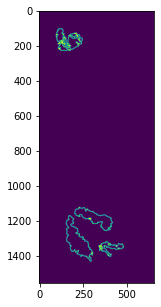

^ Code hidden above for Tissue Detection Algorithm. ^


In [3]:
def otsu_filter(channel, gaussian_blur=True):
    """Otsu filter."""
    if gaussian_blur:
        channel = cv2.GaussianBlur(channel, (5, 5), 0)
    channel = channel.reshape((channel.shape[0], channel.shape[1]))

    return cv2.threshold(
        channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

def detect_tissue(wsi, sensitivity = 3000, downsampling_factor=64):
    
    """
    Find RoIs containing tissue in WSI.
    Generate mask locating tissue in an WSI. Inspired by method used by
    Wang et al. [1]_.
    .. [1] Dayong Wang, Aditya Khosla, Rishab Gargeya, Humayun Irshad, Andrew
    H. Beck, "Deep Learning for Identifying Metastatic Breast Cancer",
    arXiv:1606.05718
    
    Parameters
    ----------
    wsi: OpenSlide/AnnotatedOpenSlide class instance
        The whole-slide image (WSI) to detect tissue in.
    downsampling_factor: int
        The desired factor to downsample the image by, since full WSIs will
        not fit in memory. The image's closest level downsample is found
        and used.
    sensitivity: int
        The desired sensitivty of the model to detect tissue. The baseline is set
        at 5000 and should be adjusted down to capture more potential issue and
        adjusted up to be more agressive with trimming the slide.
        
    Returns
    -------
    -Binary mask as numpy 2D array, 
    -RGB slide image (in the used downsampling level, in case the user is visualizing output examples),
    -Downsampling factor.
    """
    
    # Get a downsample of the whole slide image (to fit in memory)
    downsampling_factor = min(
        wsi.level_downsamples, key=lambda x: abs(x - downsampling_factor))
    level = wsi.level_downsamples.index(downsampling_factor)

    slide = wsi.read_region((0, 0), level, wsi.level_dimensions[level])
    slide = np.array(slide)[:, :, :3]

    # Convert from RGB to HSV color space
    slide_hsv = cv2.cvtColor(slide, cv2.COLOR_BGR2HSV)

    # Compute optimal threshold values in each channel using Otsu algorithm
    _, saturation, _ = np.split(slide_hsv, 3, axis=2)

    mask = otsu_filter(saturation, gaussian_blur=True)

    # Make mask boolean
    mask = mask != 0

    mask = morphology.remove_small_holes(mask, area_threshold=sensitivity)
    mask = morphology.remove_small_objects(mask, min_size=sensitivity)

    mask = mask.astype(np.uint8)
    mask_contours, tier = cv2.findContours(
        mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    return mask_contours, tier, slide, downsampling_factor

def draw_tissue_polygons(mask, polygons, polygon_type,
                              line_thickness=None):
        """
        Plot as numpy array detected tissue.
        Modeled WSIPRE github package
        
        Parameters
        ----------
        mask: numpy array 
            This is the original image represented as 0's for a starting canvas
        polygons: numpy array 
            These are the identified tissue regions
        polygon_type: str ("line" | "area")
            The desired display type for the tissue regions
        polygon_type: int
            If the polygon_type=="line" then this parameter sets thickness

        Returns
        -------
        Nunmpy array of tissue mask plotted
        """
        
        tissue_color = 1

        for poly in polygons:
            if polygon_type == 'line':
                mask = cv2.polylines(
                    mask, [poly], True, tissue_color, line_thickness)
            elif polygon_type == 'area':
                if line_thickness is not None:
                    warnings.warn('"line_thickness" is only used if ' +
                                  '"polygon_type" is "line".')

                mask = cv2.fillPoly(mask, [poly], tissue_color)
            else:
                raise ValueError(
                    'Accepted "polygon_type" values are "line" or "area".')

        return mask
    
#Base Example
tissue_contours, tier, downsampled_slide, downsampling_factor = detect_tissue(wsi, 3000,64)
base_slide_mask = np.zeros(downsampled_slide.shape[:2])
tissue_slide = draw_tissue_polygons(base_slide_mask, tissue_contours,'line', 2)
base_size = get_disk_size(downsampled_slide)
plt.imshow(tissue_slide)
plt.show()
print("^ Code hidden above for Tissue Detection Algorithm. ^")

# Sensitivity Exploration
When considering what sensitivty to choose we dont want a high enough number to remove noise, but also a low enough number to make sure we capture all of the tissue. Initial research leads to a conclusion of 3000, but I want to do more work on this in next steps.

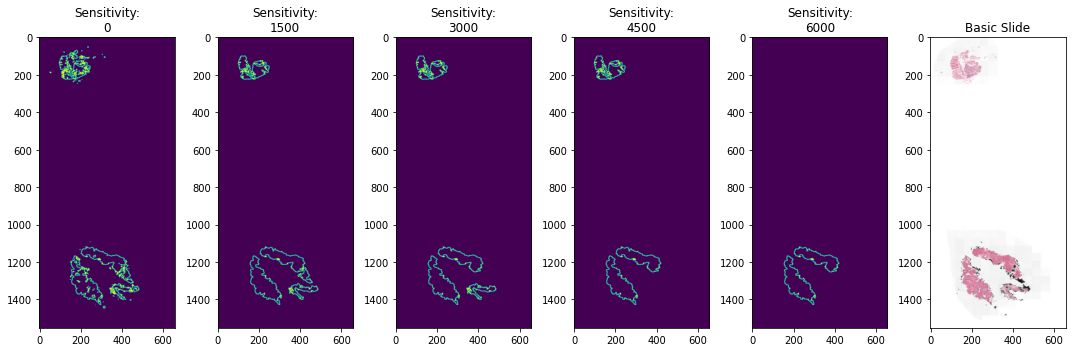

In [4]:
#Sensitivity Tests
def sensitivity_test(sensitivity):
    """Take in a given sensitivity and return tissue_slide"""
    tissue_contours, tier, downsampled_slide, downsampling_factor = detect_tissue(wsi, sensitivity,64)
    base_slide_mask = np.zeros(downsampled_slide.shape[:2])
    tissue_slide = draw_tissue_polygons(base_slide_mask, tissue_contours,'line', 2)
    return (f"Sensitivity:\n{sensitivity}",tissue_slide)

to_test = [i for i in range(0,7500,1500)]
sensitvity_results = [sensitivity_test(sensitivity) for sensitivity in to_test]
sensitvity_dict = {k:v for k,v in sensitvity_results}
sensitvity_dict["Basic Slide"] = downsampled_slide
plt = plot_figures(sensitvity_dict, 1, len(sensitvity_dict))
plt.show()

# Cutting out all space except for the identified Tissue
Once we have identified a given sensitivity and the areas it identifies as tissue we can then cut out the rest of the image. As you can see even thought we have "cut out" all non-tissue parts of the slide the size has not changed.

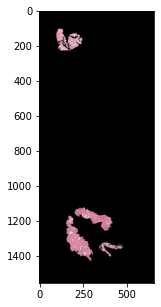

Slide Size on Disk: 3.05MB
% of original image: 100.00%


In [5]:
def tissue_cutout(tissue_slide, tissue_contours, slide):
    #https://stackoverflow.com/a/28759496
    crop_mask = np.zeros_like(tissue_slide) # Create mask where white is what we want, black otherwise
    cv2.drawContours(crop_mask, tissue_contours, -1, 255, -1) # Draw filled contour in mask
    tissue_only = np.zeros_like(slide) # Extract out the object and place into output image
    tissue_only[crop_mask == 255] = slide[crop_mask == 255]
    return tissue_only

tissue_only_slide = tissue_cutout(tissue_slide, tissue_contours, downsampled_slide)
plt.imshow(tissue_only_slide)
plt.show()

current_size = get_disk_size(tissue_only_slide)
current_pct = current_size / base_size
print(f"Slide Size on Disk: {current_size:.2f}MB")
print(f"% of original image: {current_pct*100:.2f}%")

# Getting Bounding Boxes

### Starting with simple boxes
The first method experimented with finds a minimum bounding rectangle for all of the identified countors.

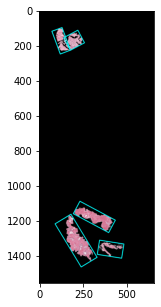

In [6]:
min_rect_bounding = tissue_only_slide.copy()
for c in tissue_contours:
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(min_rect_bounding,[box],0,(0,255,255),4)
plt.imshow(min_rect_bounding)
plt.show()

## Getting Simple Rectangle Bounding Box
This example makes a simple rectangle that captures all of the identified countors


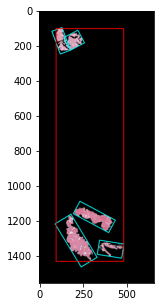

In [7]:
simple_rect_bound = min_rect_bounding.copy()
boxes = []
for c in tissue_contours:
    (x, y, w, h) = cv2.boundingRect(c)
    boxes.append([x,y, x+w,y+h])

boxes = np.asarray(boxes)
left = np.min(boxes[:,0])
top = np.min(boxes[:,1])
right = np.max(boxes[:,2])
bottom = np.max(boxes[:,3])

cv2.rectangle(simple_rect_bound, (left,top), (right,bottom), (255, 0, 0), 4)

plt.imshow(simple_rect_bound)
plt.show()

## Min-Rectagle Bounding Boxes
With the goal of minimizing the total area of the images the next method implemented concatenates all tissue contours found and builds a cumulative minimum boudning rectanlge.

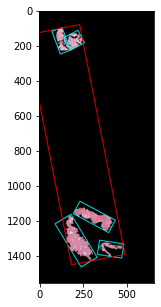

In [8]:
smart_bounding_boxes = min_rect_bounding.copy()
all_bounding_rect = cv2.minAreaRect(np.concatenate(tissue_contours))
all_bounding_box = cv2.boxPoints(all_bounding_rect)
all_bounding_box = np.int0(all_bounding_box)
cv2.drawContours(smart_bounding_boxes,[all_bounding_box],0,(255,0,0),4)
plt.imshow(smart_bounding_boxes)
plt.show()

# Cropping the Image

## Basic cropping 
Now that ROIs have been indentified we can now crop the image based on the bounding boxes. We start with a simple rectangluar crop

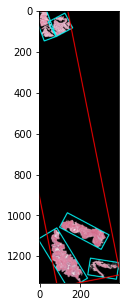

Slide Size on Disk: 1.55MB
% of original image: 50.69%


In [9]:
simple_crop = smart_bounding_boxes.copy()
crop_mask = np.zeros_like(simple_crop)
(y, x) = np.where(tissue_slide == 1)
(topy, topx) = (np.min(y), np.min(x))
(bottomy, bottomx) = (np.max(y), np.max(x))
simple_crop = simple_crop[topy:bottomy+1, topx:bottomx+1]
plt.imshow(simple_crop)
plt.show()

current_size = get_disk_size(simple_crop)
current_pct = current_size / base_size
print(f"Slide Size on Disk: {current_size:.2f}MB")
print(f"% of original image: {current_pct*100:.2f}%")

## Crop with Smart Bounding and Rotation to Minimum Size
To better reduce size we take the Smart Bounding Box we calulated and rotate the image to minimize the size while keeping everything within the bounding box. Since Prostate Biopsies are not orientated in a specific way this does not effect prediciton.

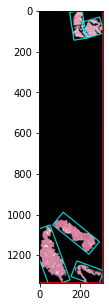

Slide Size on Disk: 1.25MB
% of original image: 40.81%


In [10]:
def getSubImage(rect, src_img):
    width = int(rect[1][0])
    height = int(rect[1][1])
    box = cv2.boxPoints(rect)

    src_pts = box.astype("float32")
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(src_img, M, (width, height))
    return warped

smart_bounding_crop = smart_bounding_boxes.copy()
smart_bounding_crop = getSubImage(all_bounding_rect,smart_bounding_crop)
plt.imshow(smart_bounding_crop)
plt.show()

current_size = get_disk_size(smart_bounding_crop)
current_pct = current_size / base_size
print(f"Slide Size on Disk: {current_size:.2f}MB")
print(f"% of original image: {current_pct*100:.2f}%")

## Remove space between countors in final bounding box
Now that we have everything but the minimum bounding boxes we can cut any blank space between the inner most areas of the contours. For visuals the bounding boxes were left, but in the full pipeline below they are removed.

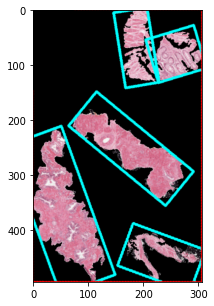

Slide Size on Disk: 0.45MB
% of original image: 14.90%


In [11]:
row_not_blank =  [row.all() for row in ~np.all(smart_bounding_crop == [255,   0,   0],axis=1)]
col_not_blank =  [col.all() for col in ~np.all(smart_bounding_crop == [255,   0,   0],axis=0)]
bounded_cut = smart_bounding_crop[row_not_blank,:]
bounded_cut = bounded_cut[:,col_not_blank]
plt.imshow(bounded_cut)
plt.show()

current_size = get_disk_size(bounded_cut)
current_pct = current_size / base_size
print(f"Slide Size on Disk: {current_size:.2f}MB")
print(f"% of original image: {current_pct*100:.2f}%")

# Whole Pipeline: Start Here for Code Only
Now that we have explained each of the steps along the way we can put the whole pipeline together.

Percent Reduced from Base Slide to Final: 86.16


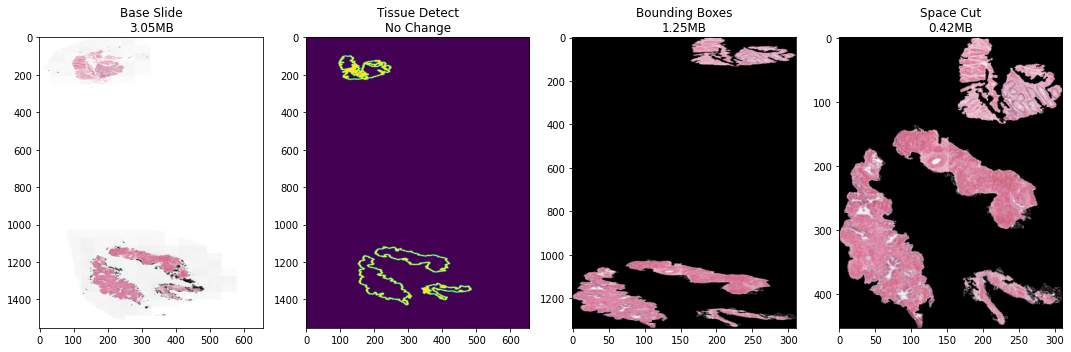

In [12]:
def detect_and_crop(image_location:str, sensitivity:int=3000, 
                    downsample_rate:int=16, show_plots:str="simple"):
    
    #Set-up dictionary for plotting
    verbose_plots = {}
    
    #Open Slide
    wsi = openslide.open_slide(image_location)
    
    #Get returns from detect_tissue()
    (tissue_contours, tier, 
     downsampled_slide, 
     downsampling_factor) = detect_tissue(wsi,
                                          sensitivity,downsample_rate)
    #Add Base Slide to verbose print
    verbose_plots[f"Base Slide\n{get_disk_size(downsampled_slide):.2f}MB"] = downsampled_slide
    
    #Get Tissue Only Slide
    base_slide_mask = np.zeros(downsampled_slide.shape[:2])
    tissue_slide = draw_tissue_polygons(base_slide_mask, tissue_contours,'line', 5)
    base_size = get_disk_size(downsampled_slide)
    tissue_only_slide = tissue_cutout(tissue_slide, tissue_contours, downsampled_slide)
    #Add Tissue Only to verbose print
    verbose_plots[f"Tissue Detect\nNo Change"] = tissue_slide
    
    #Get minimal bounding rectangle for all tissue contours
    if len(tissue_contours) == 0:
        img_id = image_location.split("/")[-1]
        print(f"No Tissue Contours - ID: {img_id}")
        return None, 1.0
    
    all_bounding_rect = cv2.minAreaRect(np.concatenate(tissue_contours))
    #Crop with getSubImage()
    smart_bounding_crop = getSubImage(all_bounding_rect,tissue_only_slide)
    #Add Bounding Boxes to verbose print
    verbose_plots[f"Bounding Boxes\n{get_disk_size(smart_bounding_crop):.2f}MB"] = smart_bounding_crop

    #Crop empty space
    #Remove by row
    row_not_blank =  [row.all() for row in ~np.all(smart_bounding_crop == [255,0,0],
                                                   axis=1)]
    space_cut = smart_bounding_crop[row_not_blank,:]
    #Remove by column
    col_not_blank =  [col.all() for col in ~np.all(smart_bounding_crop == [255,0,0],
                                                   axis=0)]
    space_cut = space_cut[:,col_not_blank]
    #Add Space Cut Boxes to verbose print
    verbose_plots[f"Space Cut\n{get_disk_size(space_cut):.2f}MB"] = space_cut
    
    #Get size change
    start_size = get_disk_size(downsampled_slide)
    final_size = get_disk_size(space_cut)
    pct_change = final_size / start_size
    
    if show_plots == "simple":
        print(f"Percent Reduced from Base Slide to Final: {(1- pct_change)*100:.2f}")
        plt.imshow(space_cut)
        plt.show() 
    elif show_plots == "verbose":
        print(f"Percent Reduced from Base Slide to Final: {(1- pct_change)*100:.2f}")
        plt = plot_figures(verbose_plots, 1, len(verbose_plots))
        plt.show()
    elif show_plots == "none":
        pass
    else:
        pass
    return space_cut, (1-pct_change)
    
numpy_result, pct_change = detect_and_crop(image_location=example_slide, show_plots="verbose")

Percent Reduced from Base Slide to Final: 66.79


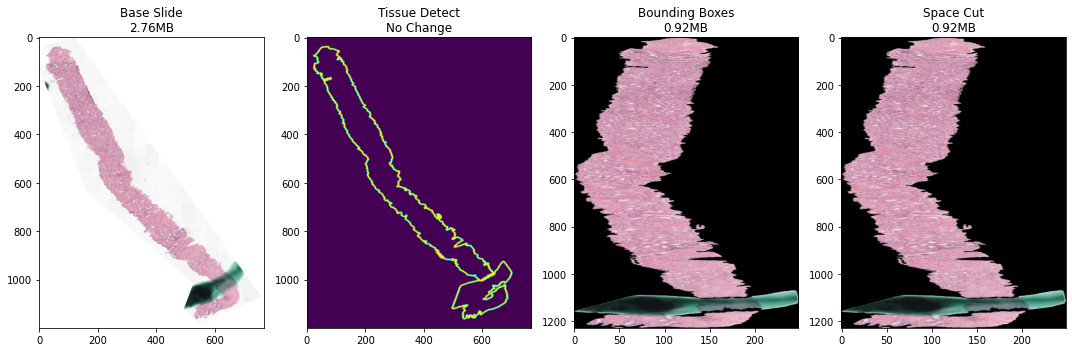

Percent Reduced from Base Slide to Final: 81.66


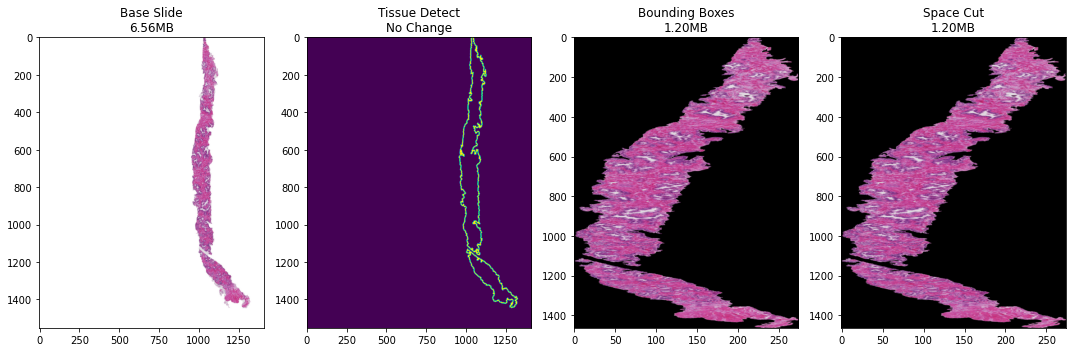

Percent Reduced from Base Slide to Final: 93.89


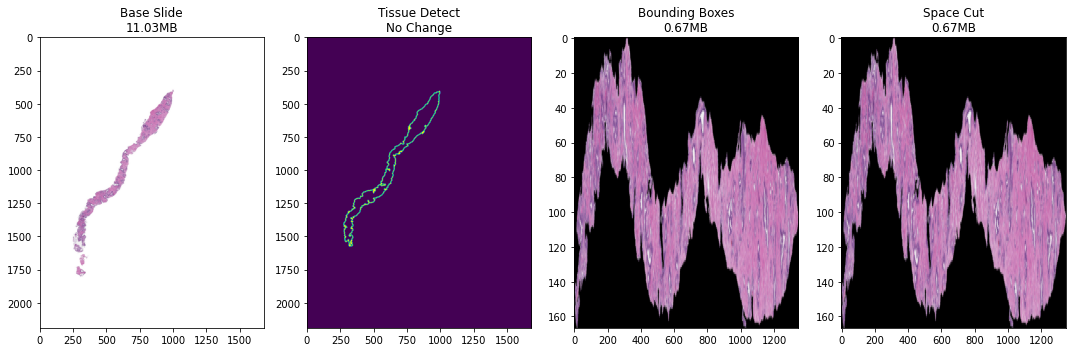

Percent Reduced from Base Slide to Final: 83.08


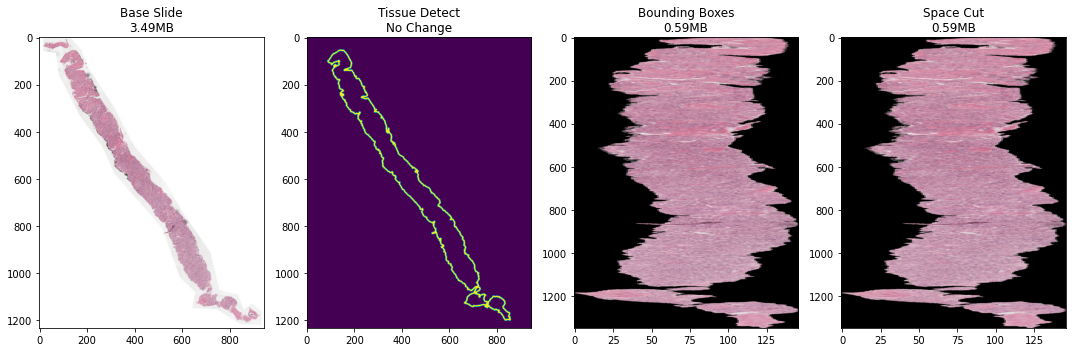

Percent Reduced from Base Slide to Final: 91.81


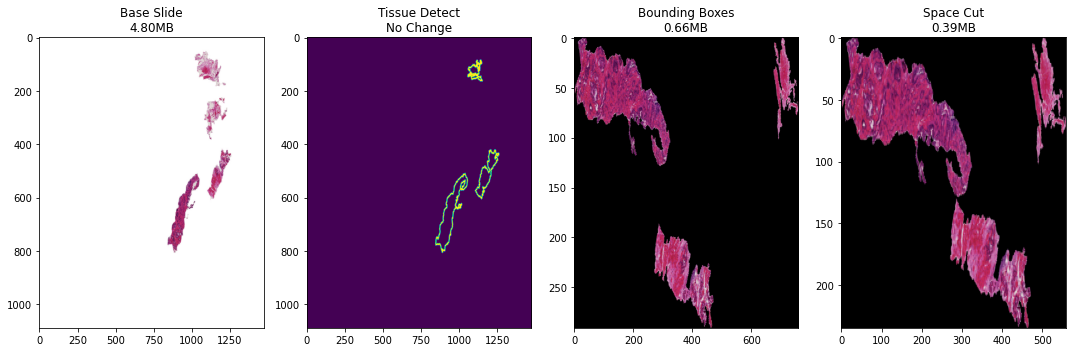

In [13]:
for sample in sample_slides:
    detect_and_crop(image_location=sample, show_plots="verbose")

# Baseline for Corpus: 67.8%
Here we try to get a average for the reduciton capacity of this code across the data corpus. We do this by sampling from the whole and taking an average of the recoded size reduciton. I have run the sampler over the whole corpus and come out with 68.95%. For speed of commiting the notebook,  I have it set to only 5% in this notebook. 

In [14]:
from statistics import mean 
from multiprocessing import Pool
from tqdm.notebook import tqdm
import gc
baseline_pct = .05
baseline_count = int(baseline_pct*len(train_data_df))
baseline_slide_ids = list(train_data_df["image_id"].sample(baseline_count))
baseline_slide_locs = [f"{slide_dir}{slide_id}.tiff" for slide_id in baseline_slide_ids]
#Nested in funciton to not take up more memory and allow mulitprocessing
def baseline_check(image_id):
    numpy_result, pct_change = detect_and_crop(image_location=image_id, show_plots="none")
    del numpy_result
    gc.collect()
    return pct_change

with Pool(processes=4) as pool:
    avg_pct_reduced = list(
        tqdm(pool.imap(baseline_check, baseline_slide_locs), total = len(baseline_slide_locs))
    )

print(f"The averge size reduced reduced from a {baseline_pct:.0%} sample of slides is {mean(avg_pct_reduced):.2%}")


The averge size reduced reduced from a 5% sample of slides is 68.80%


# Next Steps
1. Exploring how this methodology effects the mask slides
2. Timing the processing and making it more efficient
3. Checking Effectiveness on lower downsamples